In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from func import load_model, save_model, mse_loss
from keras.models import model_from_json
import h5py

2024-06-14 10:06:17.806575: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 10:06:17.868226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_name = ['correct_inputs_node_56.h5', 'std_dae_data.h5', 'data_dae_layer_8.h5', 'data_dae_layer_16.h5']
signal_labels = ['signal']

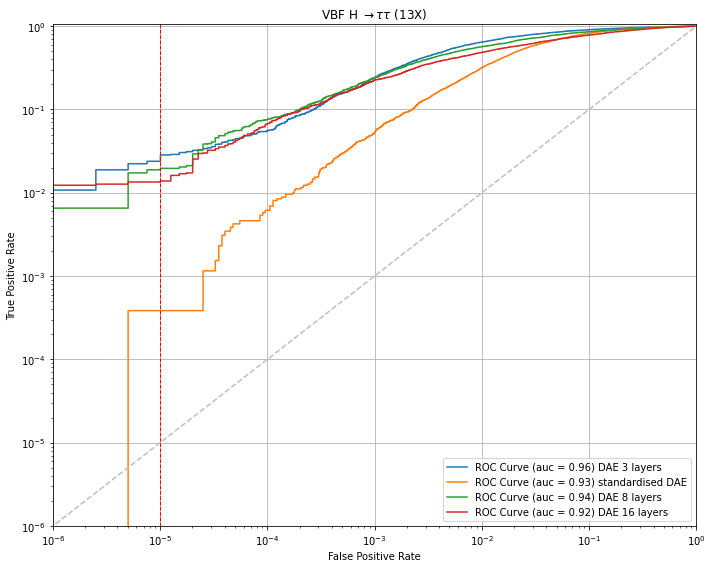

In [3]:
plt.figure(figsize=(10,8))
for data_name, name in zip(data_name, ['DAE 3 layers', 'standardised DAE', 'DAE 8 layers', 'DAE 16 layers']):
    #load data
    with h5py.File(data_name, 'r') as file:
        X_test = np.array(file['BKG_input'])
        bkg_prediction = np.array(file['BKG_predicted'])
        signal_data = np.array(file['sig_input'])
        signal_prediction = np.array(file['sig_predicted'])
    
    signal_results = []
    signal_results.append([signal_labels, signal_data, signal_prediction])
    
    # compute loss value (true, predicted)
    total_loss = []
    total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
    for i, signal_X in enumerate(signal_data):
        total_loss.append(mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy())
        
    target_background = np.zeros(total_loss[0].shape[0])
    labels = np.concatenate([['Background'], np.array(signal_labels)])
    
    for i, label in enumerate(labels):
        if i == 0: continue # background events
    
        trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
        predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

        fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

        auc_loss = auc(fpr_loss, tpr_loss)
    
        plt.plot(fpr_loss, tpr_loss, "-", label='ROC Curve (auc = %0.2f) %s'% (auc_loss, name), linewidth=1.5) #DAE Roc
        
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title(r'VBF H $\rightarrow \tau \tau$ (13X)')
plt.xlim([10**(-6), 1])
plt.ylim([10**(-6), 1.05])
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout() 
plt.savefig("ROC_DAE_combined.png")
plt.show()